<br/>
### Third level model - Predict Among Non-US Countries

Planned Model:  (NDF | (US | Not US))

First level predicts {'NDF' vs Non-NDF}

Second level predicts {'US' vs Not-US}

Third level predicts which of the Non-US countries: {'AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'other'}

#### Imports and Read in data

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [2]:
train_users_path = '../../Data/train_users_2.csv'
train_users = pd.read_csv(train_users_path)
#train_users.ix[train_users['country_destination'] != 'NDF', 'country_destination'] = 'NonNDF'
print(len(train_users))
train_users.head()

213451


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
sessions_path = '../../Data/sessions.csv'
sessions = pd.read_csv(sessions_path)
print(len(sessions))
sessions.head()

10567737


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [4]:
test_path = '../../Data/test_users.csv'
test_users = pd.read_csv(test_path)
print(len(test_users))
test_users.head()

62096


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


#### Clean data

In [212]:
# Users who have NDF
train_noPurchase = train_users[train_users['country_destination']=='NDF']
noPurchase_users = set(train_noPurchase['id'])

# Users who had a booking
train_yesPurchase = train_users[train_users['country_destination']!='NDF']
yesPurchase_users = set(train_yesPurchase['id'])

# Users who had a booking outside of US
train_nonUS_purchase = train_yesPurchase[train_yesPurchase['country_destination'] != 'US']
train_nonUS_users = set(train_nonUS_purchase ['id'])

# If you want to include US
#train_nonUS_purchase = train_yesPurchase
#train_nonUS_users = set(train_nonUS_purchase ['id'])

In [213]:
# Check that US and NDF not included - there should be 9 countries + other
set(train_nonUS_purchase['country_destination'])

{'AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'other'}

In [214]:
len(train_nonUS_purchase)

26532

#### Try without Sessions

In [215]:
#sessions_noPurchase = sessions[sessions['user_id'].isin(noPurchase_users)]
#sessions_yesPurchase = sessions[sessions['user_id'].isin(yesPurchase_users)]
#sessions_nonUS_purchase = sessions[sessions['user_id'].isin(train_nonUS_purchase)]

In [216]:
#final_train_users = train_users[train_users['id'].isin(sessions['user_id'])]
#final_train_users = train_users.copy()
#final_train_users = train_nonUS_purchase.copy()
#final_train_users.head()

In [217]:
final_train_users = train_nonUS_purchase.copy()
final_train_users.head()
#sessions_nonUS_purchase = sessions[sessions['user_id'].isin(train_nonUS_purchase)]

categories = list(train_users.columns.values)
categories = categories[4:len(categories)-1]
categories.remove('age')
categories.remove('gender')
categories
#categories = ['language']

['signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser']

In [218]:
def category_bool(catName, catItem):
    user_app = final_train_users[final_train_users[catName] == catItem]
    performed = final_train_users['id'].isin(user_app['id'])
    colname = str(catName) + '_' + str(catItem)
    final_train_users[colname] = performed

for category in categories:
    items = final_train_users[category].dropna().drop_duplicates()
    for item in items:
        category_bool(category, item)

#print(len(final_train_users[0]))
#final_train_users[final_train_users['signup_app_iOS']==True]
final_train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_browser_Avant Browser,first_browser_Mobile Firefox,first_browser_IceWeasel,first_browser_TheWorld Browser,first_browser_Iron,first_browser_SiteKiosk,first_browser_wOSBrowser,first_browser_Googlebot,first_browser_CoolNovo,first_browser_Yandex.Browser
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,False,False,False,False,False,False,False,False,False,False
12,k6np330cm1,2010-01-05,20100105060859,2010-01-18,-unknown-,NaN,basic,0,en,direct,...,False,False,False,False,False,False,False,False,False,False
15,v4d5rl22px,2010-01-07,20100107204555,2010-01-08,FEMALE,33.0,basic,0,en,direct,...,False,False,False,False,False,False,False,False,False,False
19,gdka1q5ktd,2010-01-10,20100110010817,2010-01-10,FEMALE,29.0,basic,0,en,direct,...,False,False,False,False,False,False,False,False,False,False
25,al8bcetz0g,2010-01-12,20100112131444,2010-01-15,FEMALE,26.0,basic,0,en,other,...,False,False,False,False,False,False,False,False,False,False


In [219]:
final_train_users.columns.values

array(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method',
       'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination',
       'signup_method_facebook', 'signup_method_basic',
       'signup_method_google', 'signup_flow_0', 'signup_flow_3',
       'signup_flow_2', 'signup_flow_1', 'signup_flow_8', 'signup_flow_6',
       'signup_flow_12', 'signup_flow_16', 'signup_flow_15',
       'signup_flow_21', 'signup_flow_24', 'signup_flow_25',
       'signup_flow_23', 'language_en', 'language_fr', 'language_de',
       'language_es', 'language_ko', 'language_ja', 'language_zh',
       'language_nl', 'language_ru', 'language_sv', 'language_it',
       'language_pt', 'language_fi', 'language_no', 'language_tr',
       'language_hu', 'language_pl', 'language_da', 'language_cs',
       'language_is', 'la

In [220]:
#Shuffle Training Set
cutoff = int(round(len(final_train_users) * 0.8))
trainsh = shuffle(final_train_users,random_state = 42).reset_index()
trainsh = trainsh[list(final_train_users)[15:]]
trainshX =  trainsh.drop(['country_destination'], axis=1)
trainshY = trainsh['country_destination']

In [221]:
countryList = sorted(list(set(trainsh['country_destination'])))
print(countryList)
n_classes = len(countryList)
d = defaultdict(list)
for c in countryList:
    d[c] = countryList.index(c)

def getLabel(c):
    return d[c]
    
#from sklearn.preprocessing import label_binarize
#newtrainshY = label_binarize(trainshY, classes=countryList)

newtrainshY = trainshY.apply(getLabel)

['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'other']


In [222]:
print cutoff

21226


In [223]:
#Split into Train and Validation
X = np.array(trainshX)
#y = np.array(trainshY != 'NDF')
y = newtrainshY
Xtrain = np.array(X[:cutoff], dtype=int)
ytrain = np.array(y[:cutoff], dtype=int)
Xval = np.array(X[cutoff:], dtype=int)
yval = np.array(y[cutoff:], dtype=int)
#Xtrain = Xtrain[:, np.newaxis]
#Xval = Xval[:, np.newaxis]

In [224]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer,  roc_curve, auc
from scipy.stats import randint as sp_randint

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

## Random Forest
#from sklearn.ensemble import RandomForestClassifier
#params = {'n_estimators': 100, 'max_depth': 9, 'verbose':1} 
#clf = RandomForestClassifier(**params)

## Gradient Boosting (sklearn)
#from sklearn.ensemble import GradientBoostingClassifier
#params = {'n_estimators': 30, 'max_depth': 10, 'learning_rate': 0.1, 'loss':'deviance', 'verbose':1} 
#clf = GradientBoostingClassifier(**params)

## One vs Rest Multiclass with SVC
from sklearn.multiclass import OneVsRestClassifier
#clf =  OneVsRestClassifier(LinearSVC(random_state=0, probability=True, verbose=True))

#params = {'n_estimators': 3, 'max_depth': 10, 'learning_rate': 0.1,  'criterion':'mae', 'verbose':1} 
#clf =  OneVsRestClassifier(GradientBoostingClassifier(**params))
clf =  OneVsRestClassifier(GradientBoostingClassifier(verbose=1))

##  Adaboost
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.tree import DecisionTreeClassifier
#clf = AdaBoostClassifier(
#    DecisionTreeClassifier(max_depth=9),
#    n_estimators=600,
#    learning_rate=0.1)

In [225]:
print(np.shape(Xtrain))
print(np.shape(ytrain))
print(np.shape(Xval))
print(np.shape(yval))

(21226, 113)
(21226,)
(5306, 113)
(5306,)


In [226]:
clf.fit(Xtrain, ytrain)
#probs = clf.predict_proba(Xval)

      Iter       Train Loss   Remaining Time 
         1           0.1955            2.93s
         2           0.1950            3.17s
         3           0.1948            3.26s
         4           0.1945            3.88s
         5           0.1943            3.83s
         6           0.1942            3.79s
         7           0.1941            4.02s
         8           0.1940            3.87s
         9           0.1939            3.89s
        10           0.1937            3.86s
        20           0.1926            3.51s
        30           0.1914            3.02s
        40           0.1907            2.53s
        50           0.1900            2.08s
        60           0.1892            1.65s
        70           0.1889            1.22s
        80           0.1886            0.81s
        90           0.1883            0.40s
       100           0.1881            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.4121            3.25s
        

OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False),
          n_jobs=1)

In [208]:
probs = clf.decision_function(Xval)

In [209]:
probs[0]

array([-5.18081147, -3.94080742, -4.47962715, -3.6777033 , -2.68417458,
       -3.6156161 , -3.38944344, -4.7375033 , -5.98020365,  0.82344045,
       -2.10693816])

In [227]:
import sklearn.metrics as metrics

score = []
fpr = []
tpr = []
roc_auc = []

for i in range(len(countryList)):
    
    pred_val = clf.predict_proba(Xval)[:,i]
    yval_temp = (yval==i)
    f,t,_ = metrics.roc_curve(yval_temp,pred_val)

    auc = metrics.roc_auc_score(yval_temp,pred_val)
    
    fpr.append(f)
    tpr.append(t)
    roc_auc.append(auc)

print roc_auc

[0.52614768334549777, 0.54702992715807008, 0.54745607599302615, 0.52990750745852788, 0.54853125470997699, 0.56076516494444206, 0.53125350734988352, 0.48231999900901901, 0.5026195535745136, 0.5687206107566436]


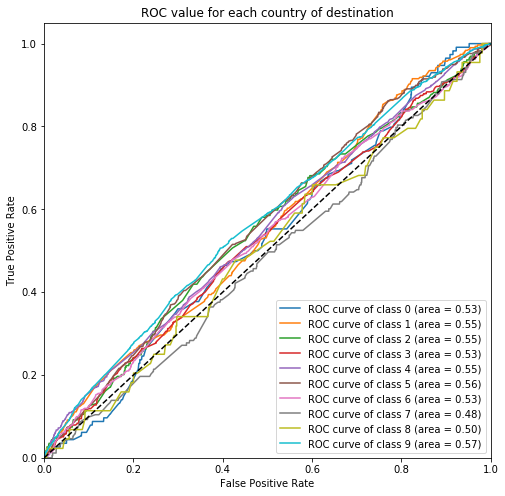

In [228]:
#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(n_classes), colors):

fig, ax = plt.subplots(figsize = (8,8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], 
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC value for each country of destination')
plt.legend(loc="lower right")
plt.show()